<a href="https://colab.research.google.com/github/sdmadhav/instacart_ml_project/blob/main/data_mining_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

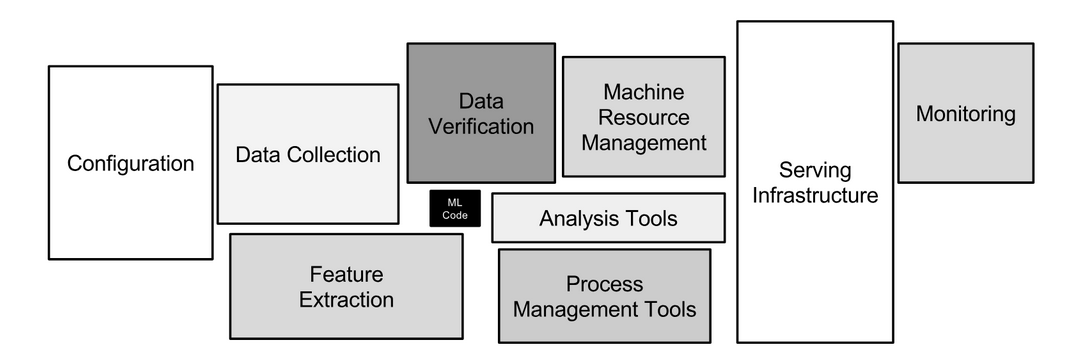

# 01 Utils

In [ ]:
from functools import lru_cache
from pathlib import Path
from typing import Literal

import numpy as np
from numpy.typing import NDArray
from sklearn.datasets import make_classification


NUM_FEATURES = 10
NUM_TUPLES = 20000

ANSWER_TO_EVERYTHING = 42
MODEL_METRIC = Literal["accuracy", "precision", "recall", "f1"]

import os
def get_project_root() -> Path:
    """get_project_root returns the absolute path to the project root directory.

    The result is cached, so subsequent calls return immediately.
    """
    # Get the current working directory
    cwd = os.getcwd()

    # Navigate up until we find the pyproject.toml file
    # for parent in Path(cwd).parents:
    #     if (parent / "pyproject.toml").exists():
    #         return parent
    return cwd

    # If we couldn't find the root, raise an exception
    raise FileNotFoundError("Couldn't find the project root directory.")







In [ ]:
# def create_dataset(
#     num_tuples: int = NUM_TUPLES, num_features: int = NUM_FEATURES, random_state: int = 42
# ) -> NDArray[np.float64]:
#     """create_dataset creates a toy synthetic dataset."""
#     X, y = make_classification(
#         random_state=random_state,
#         n_samples=num_tuples,
#         n_features=num_features,
#         n_informative=int(0.6 * num_features),
#         n_redundant=int(0.4 * num_features),
#         n_repeated=0,
#         n_classes=2,
#         n_clusters_per_class=2,
#         shuffle=True,
#     )

#     # Combine the data for ease of use
#     return np.column_stack((X, y))

In [ ]:
def create_dataset(
    num_tuples: int = 10000, num_features: int = 10, num_categorical: int = 2, random_state: int = 42
) -> np.ndarray:
    """Create a synthetic dataset with both numerical and categorical features."""
    # Generate numerical features
    X_numeric, y = make_classification(
        random_state=random_state,
        n_samples=num_tuples,
        n_features=num_features - num_categorical,  # The number of numerical features
        n_informative=int(0.6 * (num_features - num_categorical)),
        n_redundant=int(0.4 * (num_features - num_categorical)),
        n_repeated=0,
        n_classes=2,
        n_clusters_per_class=2,
        shuffle=True,
    )

    # Generate categorical features (randomly chosen categories)
    categorical_data = []
    for _ in range(num_categorical):
        # Random categories, e.g., "Category_1", "Category_2", "Category_3"
        categorical_data.append(np.random.choice([0, 1, 2], size=num_tuples))

    # Combine numerical and categorical features
    X = np.column_stack((X_numeric, *categorical_data))

    # Combine the features with the target variable
    return np.column_stack((X, y))

# # Example usage
# dataset = create_dataset(num_tuples=10000, num_features=10, num_categorical=2)
# DATASET_FILE_PATH = Path("dataset_with_classes.npz")
# save_dataset(dataset, DATASET_FILE_PATH )
# print(dataset.shape)  # This will print the shape of the dataset

In [ ]:
def save_dataset(X_y: NDArray[np.float64], file_path: Path) -> None:  # noqa: N803
    """save_dataset stores the data to a file with a hard coded name."""
    np.savez_compressed(file_path, data=X_y)
    print(f"Saved to file: {file_path}")


def load_dataset(file_path: Path) -> NDArray[np.float64]:
    """load_dataset loads a dataset from a hard coded file name."""
    loaded_data = np.load(file_path)
    return loaded_data["data"]

In [ ]:
dataset = create_dataset()
DATASET_FILE_PATH = Path("dataset.npz")
save_dataset(dataset, DATASET_FILE_PATH )

Saved to file: dataset.npz


In [ ]:
dataset.shape

(10000, 11)

# 02 Pipeline Configs

In [ ]:
# GiG

from abc import ABC, abstractmethod
from datetime import datetime
from enum import Enum
from typing import Any, Literal, Self

import numpy as np
from numpy.typing import NDArray
from pydantic import BaseModel, ConfigDict, Field, FilePath, model_validator
from rich.console import Console
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

console = Console()


VALID_CLASSIFIER_TYPES = DecisionTreeClassifier | KNeighborsClassifier | GaussianNB


################## Begin: Do not change anything below##################


class ValidClassifierNames(str, Enum):
    """ValidClassifierNames is an Enum to control which classifiers are used in ML pipeline."""

    DT = "DecisionTree"
    NB = "NaiveBayes"
    KNN = "KNN"

    # By default, Enums output the "name" (eg DT, NB and KNN)
    # Make it output the value
    def __str__(self) -> str:
        """Customize the display name of the enum variable."""
        return str(self.value)


class MLModelConfig(BaseModel, ABC):
    """MLModelConfigBaseClass is an abstract base class."""

    # Do not allow any new fields when creating this class.
    # Pydantic freaks out when you use NDArray type annotation
    # So use the arbitrary_types_allowed config.

    model_config = ConfigDict(extra="forbid", arbitrary_types_allowed=True)

    @abstractmethod
    def create_classifier(self) -> VALID_CLASSIFIER_TYPES:
        """create_classifier is an abstract function that can create appropriate classifiers."""

    @abstractmethod
    def get_classifier_name(self) -> ValidClassifierNames:
        """get_classifier_name outputs the name of the classifier."""

    @abstractmethod
    def get_hyper_param_grid(self) -> dict[str, list]:
        """get_hyper_param_grid outputs dict using for HP tuning."""


################## End: Do not change anything below##################


##################Start modifying here##################
class DatasetConfig(BaseModel):
    """DatasetConfig class is used to represent a dataset."""

    # Do not allow any new fields when creating this class.
    # Pydantic freaks out when you use NDArray type annotation
    # So use the arbitrary_types_allowed config.
    model_config = ConfigDict(extra="forbid", arbitrary_types_allowed=True)
    file_path: FilePath = Field(..., description="Path to the dataset file")
    train_size: float = Field(0.3, ge=0.1, le=0.5, description="Proportion of data to use for training")
    validation_size: float = Field(0.1, ge=0.1, le=0.2, description="Proportion of data to use for validation")
    test_size: float = Field(0.1, ge=0.1, le=0.3, description="Proportion of data to use for testing")
    production_size: float = Field(
        0.5, ge=0.1, le=0.5, description="Proportion of data to use for Production"
    )

    # validate the sum of the sizes
    @model_validator(mode="after")
    def validate_sum_of_sizes(self):
        """validate_sum_of_sizes checks if the sum of sizes is 1."""
        sum_of_sizes = self.train_size + self.validation_size + self.test_size + self.production_size
        if sum_of_sizes != 1:
            raise ValueError("Fields train_size, validation_size, test_size, production_size should add up to 1.")
        return self



    ################## Begin: Do not change anything below##################

    full_data: NDArray[np.float64] = np.array([])
    train_X: NDArray[np.float64] = np.array([])  # noqa: N815
    validation_X: NDArray[np.float64] = np.array([])  # noqa: N815
    train_and_validation_X: NDArray[np.float64] = np.array([])  # noqa: N815
    test_X: NDArray[np.float64] = np.array([])  # noqa: N815
    train_val_test_X: NDArray[np.float64] = np.array([])  # noqa: N815
    production_X: NDArray[np.float64] = np.array([])  # noqa: N815

    train_y: NDArray[np.float64] = np.array([])
    validation_y: NDArray[np.float64] = np.array([])
    train_and_validation_y: NDArray[np.float64] = np.array([])
    test_y: NDArray[np.float64] = np.array([])
    train_val_test_y: NDArray[np.float64] = np.array([])
    production_y: NDArray[np.float64] = np.array([])

    def load_data(self) -> None:
        """load_data reads a npz file and splits the dataset based on the configs."""
        self.full_data = load_dataset(self.file_path)

        num_tuples = len(self.full_data)

        # We will split X and y into 4 parts.
        # If the config is 0.3, 0.1, 0.1 and 0.5, then
        # for 20K, the splits will be 0-6K, 6001-8K, 8001-10K, 10001-20K

        index_start, index_end = 0, int(self.train_size * num_tuples)
        temp_Xy = self.full_data[0:index_end]
        self.train_X, self.train_y = temp_Xy[:, :-1], temp_Xy[:, -1]

        index_start, index_end = index_end, index_end + int(self.validation_size * num_tuples)
        temp_Xy = self.full_data[index_start:index_end]
        self.validation_X, self.validation_y = temp_Xy[:, :-1], temp_Xy[:, -1]

        self.train_and_validation_X = np.vstack((self.train_X, self.validation_X))
        self.train_and_validation_y = np.hstack((self.train_y, self.validation_y))

        index_start, index_end = index_end, index_end + int(self.test_size * num_tuples)
        temp_Xy = self.full_data[index_start:index_end]
        self.test_X, self.test_y = temp_Xy[:, :-1], temp_Xy[:, -1]

        temp_Xy = self.full_data[0:index_end]
        self.train_val_test_X, self.train_val_test_y = temp_Xy[:, :-1], temp_Xy[:, -1]

        index_start, index_end = index_end, num_tuples
        temp_Xy = self.full_data[index_start:index_end]
        self.production_X, self.production_y = temp_Xy[:, :-1], temp_Xy[:, -1]

    def print_dataset_stats(self) -> None:
        """print_stats just prints some basic statistics."""
        console.print(f"Train: {self.train_X.shape}, {self.train_y.shape}")
        console.print(f"Validation: {self.validation_X.shape}, {self.validation_y.shape}")
        console.print(
            f"Train+Val: {self.train_and_validation_X.shape}, {self.train_and_validation_y.shape}"
        )
        console.print(f"Test: {self.test_X.shape}, {self.test_y.shape}")
        console.print(
            f"Train+Val+Test: {self.train_val_test_X.shape}, {self.train_val_test_y.shape}"
        )
        console.print(f"Production: {self.production_X.shape}, {self.production_y.shape}")


################## End: Do not change anything below##################


class DecisionTreeConfig(MLModelConfig):
    """DecisionTreeConfig specifies params to create DecisionTreeClassifier."""

    '''

    ml_model_type should be a literal decision_tree
    Should have a variable called random_state that is an integer whose default value is utils.ANSWER_TO_EVERYTHING .
    Should have a variable called criterion that can only take three values : gini, entropy and log_loss. It should have a description as "Function to measure the quality of a split".
    Create a variable called max_depth that is an integer with a default value of 1 and takes a value that is at least 1. It should have a description of "Maximum depth of the tree".
    The variable min_samples_split should be an integer with a default value of 2 and should be at least 2. It should have a description "Minimum number of samples required to split an internal node"

    '''
    ml_model_type: Literal["decision_tree"] = "decision_tree"
    random_state: int = ANSWER_TO_EVERYTHING

    criterion: Literal["gini", "entropy", "log_loss"] = Field(
        "gini", description="Function to measure the quality of a split"
    )
    max_depth: int = Field(1, ge=1, description="Maximum depth of the tree")
    min_samples_split: int = Field(2, ge=2, description="Minimum number of samples required to split an internal node")

    ################## Begin: Do not change anything below##################
    def create_classifier(self) -> DecisionTreeClassifier:
        """create_classifier returns a DecisionTreeClassifier that is appropriately initialized."""
        return DecisionTreeClassifier(
            random_state=self.random_state,
            criterion=self.criterion,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
        )

    def get_classifier_name(self) -> ValidClassifierNames:
        """get_classifier_name outputs the name of the classifier."""
        return ValidClassifierNames.DT

    def get_hyper_param_grid(self) -> dict[str, list]:
        """get_hyper_param_grid outputs dict using for HP tuning."""
        return {
            "criterion": ["gini", "entropy", "log_loss"],
            "max_depth": [4, 8, 16],
            "min_samples_split": [4, 8, 16],
        }


################## End: Do not change anything below##################


class NaiveBayesConfig(MLModelConfig):
    """NaiveBayesConfig specifies params to create naive_bayes."""

    ml_model_type: Literal["naive_bayes"] = "naive_bayes"
    '''
    it should have a field called variant that only takes the value "gaussian" and the description must be "Variant of Naive Bayes to use".
    '''
    variant: Literal["gaussian"] = Field("gaussian", description="Variant of Naive Bayes to use")

    ################## Begin: Do not change anything below##################
    def create_classifier(self) -> GaussianNB:
        """create_classifier returns a DecisionTreeClassifier that is appropriately initialized."""
        return GaussianNB()

    def get_classifier_name(self) -> ValidClassifierNames:
        """get_classifier_name outputs the name of the classifier."""
        return ValidClassifierNames.NB

    def get_hyper_param_grid(self) -> dict[str, list]:
        """get_hyper_param_grid outputs dict using for HP tuning."""
        return {
            "var_smoothing": [1e-9, 1e-8, 1e-4],
        }

    ################## End: Do not change anything below##################


class KNNConfig(MLModelConfig):
    """KNNConfig specifies params to create KNeighborsClassifier."""

    '''
    ml_model_type should be a literal value knn
    n_neighbors is an integer with a default value of 5 and should be greater than or equal to 1. The description should be "Number of neighbors to use".
    weights should take only two possible values: uniform or distance. The default value should be uniform and must have a description "Weight function used in prediction".
    p should be an integer with default value of 2 and must be between 1 and 3. The description must be "Power parameter for the Minkowski metric"
    '''

    ml_model_type: Literal["knn"] = "knn"
    n_neighbors: int = Field(5, ge=1, description="Number of neighbors to use")
    weights: Literal["uniform", "distance"] = Field(
        "uniform", description="Weight function used in prediction"
    )
    p: int = Field(2, ge=1, le=3, description="Power parameter for the Minkowski metric")

    ################## Begin: Do not change anything below##################
    def create_classifier(self) -> KNeighborsClassifier:
        """create_classifier returns a DecisionTreeClassifier that is appropriately initialized."""
        return KNeighborsClassifier(n_neighbors=self.n_neighbors, weights=self.weights, p=self.p)

    def get_classifier_name(self) -> ValidClassifierNames:
        """get_classifier_name outputs the name of the classifier."""
        return ValidClassifierNames.KNN

    def get_hyper_param_grid(self) -> dict[str, list]:
        """get_hyper_param_grid outputs dict using for HP tuning."""
        return {
            "n_neighbors": [1, 2, 4, 8, 16],
            "weights": ["uniform", "distance"],
            "p": [1, 2, 3, 4],
        }


################## End: Do not change anything below##################


########################Begin: Do not modify anything below########################
class SimpleMLPipeline(BaseModel):
    """SimpleMLPipeline is an abstraction of ML pipeline to build and evaluate a classifier."""

    # Do not allow any new fields when creating this class.
    # Pydantic freaks out when you use NDArray type annotation
    # So use the arbitrary_types_allowed config.

    model_config = ConfigDict(extra="forbid", arbitrary_types_allowed=True)

    name: str = Field(default="", description="Name of the ML pipeline")
    created_at: datetime = Field(
        default_factory=datetime.now, description="Timestamp of pipeline creation"
    )

    dataset: DatasetConfig
    ml_model_config: MLModelConfig

    classifier: VALID_CLASSIFIER_TYPES | None = None

    def get_prediction_class(self, features: list[float]) -> int:
        """make_prediction takes a single item and outputs the prediction probabilities."""
        assert self.classifier is not None
        single_item = np.array(features).reshape(1, -1)
        prediction = self.classifier.predict(single_item)
        return int(prediction[0])

    def get_prediction_probabilities(self, features: list[float]) -> tuple[float, float]:
        """make_prediction takes a single item and outputs the prediction probabilities."""
        assert self.classifier is not None
        single_item = np.array(features).reshape(1, -1)
        prediction_proba = self.classifier.predict_proba(single_item)
        return tuple(prediction_proba[0].tolist())

    def print_evaluation_results(self, verbose: bool = True) -> dict:  # noqa: FBT001, FBT002
        """Evaluate is a dummy function that prints the accuracy of a classifier."""
        assert self.classifier is not None
        pred_y = self.classifier.predict(self.dataset.test_X)
        name = self.ml_model_config.get_classifier_name()
        if verbose:
            console.print(f"[bold red]Classification report for {name}: [/bold red]")
            console.print(classification_report(self.dataset.test_y, pred_y))
        report = classification_report(self.dataset.test_y, pred_y, output_dict=True)
        assert isinstance(report, dict)
        return report

    def train(self) -> None:
        """Train creates a classifier and fits it to data."""
        self.dataset.load_data()
        self.classifier = self.ml_model_config.create_classifier()
        self.classifier.fit(self.dataset.train_X, self.dataset.train_y)

    def run_pipeline(self, verbose: bool = True) -> None:  # noqa: FBT001, FBT002
        """run_pipeline runs the simple ML pipeline."""
        self.train()
        self.print_evaluation_results(verbose)


# Advanced: Okay to ignore.
# Two interesting things to note here:
#  1. First, we are using | to test multiple values in single match case.
#  2. We are using the name and value params of an Enum to test both cases
def get_classifier_config(classifier_name: str) -> MLModelConfig:
    """get_classifier_config returns a model config object with default params."""
    match classifier_name:
        case ValidClassifierNames.DT.name | ValidClassifierNames.DT.value:
            return DecisionTreeConfig()
        case ValidClassifierNames.KNN.name | ValidClassifierNames.KNN.value:
            return KNNConfig()
        case ValidClassifierNames.NB.name | ValidClassifierNames.NB.value:
            return NaiveBayesConfig()
        case _:
            raise ValueError(f"Invalid classifier name {classifier_name}")


def get_simple_ml_pipeline(classifier_name: str = "DT") -> SimpleMLPipeline:
    """get_simple_ml_pipeline produces a pipeline object with default params."""
    d = DatasetConfig(file_path=DATASET_FILE_PATH)
    ml_model_config = get_classifier_config(classifier_name)
    return SimpleMLPipeline(dataset=d, ml_model_config=ml_model_config)


def get_prediction_probabilities(
    features: list[float],
    classifier: str,
) -> tuple[float, float]:
    """get_prediction_probabilities creates a pipeline and returns probabilities."""
    pipeline = get_simple_ml_pipeline(classifier)
    pipeline.train()
    return pipeline.get_prediction_probabilities(features)


def get_prediction_class(
    features: list[float],
    classifier: str,
) -> int:
    """get_prediction_probabilities creates a pipeline and returns probabilities."""
    pipeline = get_simple_ml_pipeline(classifier)
    pipeline.train()
    return pipeline.get_prediction_class(features)


########################End: Do not modify anything below########################

if __name__ == "__main__":
    get_simple_ml_pipeline("DT").run_pipeline()
    get_simple_ml_pipeline("KNN").run_pipeline()
    get_simple_ml_pipeline("NB").run_pipeline()


Classification report for DecisionTree: 

precision    recall  f1-score   support

         0.0       0.64      0.86      0.74       514
         1.0       0.77      0.50      0.61       486

    accuracy                           0.68      1000
   macro avg       0.71      0.68      0.67      1000
weighted avg       0.71      0.68      0.67      1000

Classification report for KNN: 

precision    recall  f1-score   support

         0.0       0.93      0.90      0.91       514
         1.0       0.89      0.92      0.91       486

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

Classification report for NaiveBayes: 

precision    recall  f1-score   support

         0.0       0.71      0.90      0.79       514
         1.0       0.85      0.61      0.71       486

    accuracy                           0.76      1000
   macro avg       0.78      0.75      0.75      1000
weighted avg       0.78      0.76      0.75      1000

# 03 Model Evaluation

---



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

ml_pipeline = get_simple_ml_pipeline()
ml_pipeline.train()
classifier = ml_pipeline.classifier
test_X, test_y = ml_pipeline.dataset.test_X, ml_pipeline.dataset.test_y
assert classifier is not None

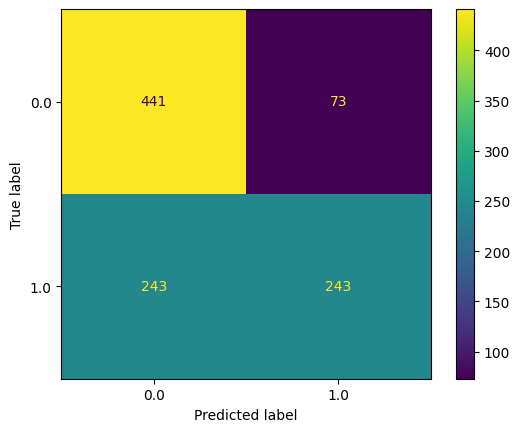

In [ ]:
ConfusionMatrixDisplay.from_estimator(classifier, test_X, test_y)

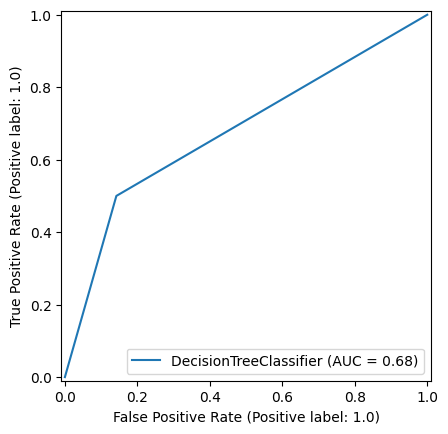

In [ ]:
RocCurveDisplay.from_estimator(classifier, test_X, test_y)

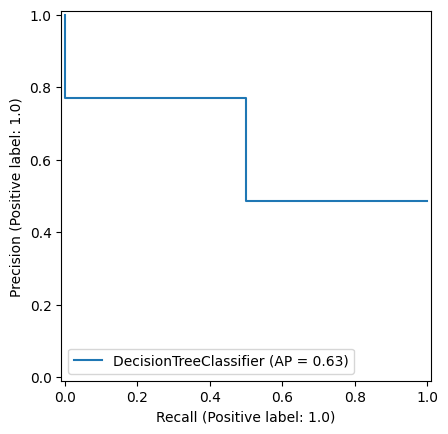

In [ ]:
PrecisionRecallDisplay.from_estimator(classifier, test_X, test_y)

## Evaluation with Custom Matrix

In [ ]:
from collections.abc import Callable

import numpy as np
from numpy.typing import NDArray
from sklearn.metrics import confusion_matrix, make_scorer


# Given the cost matrix, cost_00, cost_01, cost_10, cost_11,
# output the classifier cost score.
# It will return the closure of the scorer.


def create_cost_based_scorer(
    cost_00: float, cost_01: float, cost_10: float, cost_11: float
) -> Callable:
    def cost_function(y: NDArray, y_pred: NDArray, **kwargs) -> float:  # noqa: ANN003, ARG001
        cm = confusion_matrix(y, y_pred)
        cost = (
            cm[0, 0] * cost_00
            + cm[0, 1] * cost_01
            + cm[1, 0] * cost_10
            + cm[1, 1] * cost_11
        )
        return cost

    # Using meta programming, we have returned a function that is frozen
    # to use cost_00, cost_01, cost_10, and cost_11
    # when we call with different values for
    # cost_00, cost_01, cost_10, and cost_11, we will get a different function
    # This function can then be sent to make_scorer to get outputs
    return cost_function


# This function converts cost_function into a scorer function
# that can be used for training classifiers, hyper parameter tuning and error estimation.
# All we need to do is call the make_scorer and tell it that it is a loss function.
# So classifiers with higher values are worse than those with lower values.


def create_loss_function_scorer( cost_00: float, cost_01: float, cost_10: float, cost_11: float ) -> Callable:

    return make_scorer(
        create_cost_based_scorer(cost_00, cost_01, cost_10, cost_11), greater_is_better=False
    )




In [ ]:
def get_predicted_and_actual_y(classifier: str) -> tuple[NDArray, NDArray]:
    ml_pipeline = get_simple_ml_pipeline(classifier)
    ml_pipeline.train()

    test_X, test_y = ml_pipeline.dataset.test_X, ml_pipeline.dataset.test_y
    assert ml_pipeline.classifier is not None
    pred_y = ml_pipeline.classifier.predict(test_X)

    return test_y, pred_y

In [ ]:

def test_custom_metric1(classifier: str) -> None:
    test_y, pred_y = get_predicted_and_actual_y(classifier)
    cm = confusion_matrix(test_y, pred_y)

    # Test with first custom scorer
    custom_scorer = create_cost_based_scorer(0, 1, 1, 0) # pass the cost values here
    result = custom_scorer(test_y, pred_y)
    expected = np.sum(cm * np.array([[0, 1], [1, 0]]))

    if result == expected:
        console.print(f"[bold green]Test with first custom score passed [bold red]Classifier: {classifier}[/bold red] - [bold yellow]with result: {result}[/bold yellow]")
    else:
        console.print(f"[bold green]Test with first custom score failed [bold red]Classifier: {classifier}[/bold red] - [bold yellow]with result: {result} (expected: {expected})[/bold yellow]")

    # Test with second custom scorer
    custom_scorer = create_cost_based_scorer(1, 2, 2, 0)
    result = custom_scorer(test_y, pred_y)
    expected = np.sum(cm * np.array([[1, 2], [2, 0]]))

    if result == expected:
        console.print(f"[bold green]Test with second custom score passed [bold red]Classifier: {classifier}[/bold red] - [bold yellow]with result: {result}[/bold yellow]")
    else:
        console.print(f"[bold green]Test with second custom score failed [bold red]Classifier: {classifier}[/bold red] - [bold yellow]with result: {result} (expected: {expected})[/bold yellow]")

# classifiers list
classifiers = [v.value for v in ValidClassifierNames]
for classifier in classifiers:
    test_custom_metric1(classifier)


Test with first custom score passed Classifier: DecisionTree - with result: 316

Test with second custom score passed Classifier: DecisionTree - with result: 1073

Test with first custom score passed Classifier: NaiveBayes - with result: 244

Test with second custom score passed Classifier: NaiveBayes - with result: 949

Test with first custom score passed Classifier: KNN - with result: 90

Test with second custom score passed Classifier: KNN - with result: 641

# 04 Error Estimation in production scenarios



In machine learning, **error estimation** is a technique used to predict the performance of a model in real-world or production scenarios. It helps assess how well a model will generalize beyond the training data and provides insights into the potential performance on unseen data.

In **Error Estimation**, we explore several methods to estimate the **generalization error** of a model using different approaches. The following five approaches are implemented to estimate model error:

1. **TRAIN**
- **Concept**: This method assumes that the model's performance on the **validation** set is the same as on the **production** data.
- **Implementation**:
  - Fit the model on the **training data**.
  - Evaluate its accuracy on the **test data**.
  
2. **TRAIN_VAL**
- **Concept**: Similar to the **TRAIN** method, but uses **training + validation** data combined to fit the model. Assumes the performance on this combined dataset is the same as on the production data.
- **Implementation**:
  - Fit the model on the combined **training + validation data**.
  - Evaluate accuracy on the **test data**.

3. **CV_TRAIN_VAL**
- **Concept**: This method uses **cross-validation** on the combined **training + validation data** to estimate error. Assumes that cross-validation will provide a good estimate of the model's performance on production data.
- **Implementation**:
  - Perform **cross-validation** on the **training + validation** data using `cross_val_score`.
  - Compute the mean accuracy over all folds and use it as the estimate.

4. **BOOTSTRAP_632**
- **Concept**: A more sophisticated approach using **bootstrap sampling** to estimate the error. This method combines bootstrap resampling with a point estimate of the generalization error.
- **Implementation**:
  - Use the `bootstrap_point632_score` function.
  - Set `n_splits` to the desired number of bootstrap trials.
  - Set `random_seed` for reproducibility.

5. **BOOTSTRAP_OOB**
- **Concept**: Similar to the **BOOTSTRAP_632** method, but this method uses **out-of-bag (OOB)** samples as the method for estimating error.
- **Implementation**:
  - Use `bootstrap_point632_score` with the `oob` option.
  - This method also provides **confidence intervals** for the error estimate (e.g., 95% confidence).

6. Key Points:
- **TRAIN** and **TRAIN_VAL** estimate error based on direct performance on validation and combined datasets, respectively.
- **CV_TRAIN_VAL** uses cross-validation for a more robust estimate.
- **BOOTSTRAP_632** and **BOOTSTRAP_OOB** offer advanced bootstrap methods for error estimation with confidence intervals.

These methods give a way to estimate model’s potential performance in production, helping us decide the best approach to take.

---



In [ ]:
from enum import Enum

import numpy as np
from mlxtend.evaluate import bootstrap_point632_score
from pydantic import BaseModel, ConfigDict
from rich import print
from rich.table import Table
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [ ]:
NUM_BOOTSTRAP_TRIALS = 200

In [ ]:
class ErrorEstimationAlgos(str, Enum):
    """ErrorEstimationAlgos is an Enum to control which classifiers are used in ML pipeline."""

    TRAIN = "TRAIN"
    TRAIN_VAL = "TRAIN_VAL"
    CV_TRAIN_VAL = "CV_TRAIN_VAL"
    BOOTSTRAP_632 = "BOOTSTRAP_632"
    BOOTSTRAP_OOB = "BOOTSTRAP_OOB"

    # By default, Enums output the "name" (eg DT, NB and KNN)
    # Make it output the value
    def __str__(self) -> str:
        """Customize the display name of the enum variable."""
        return str(self.value)


In [ ]:
class ErrorEstimator(BaseModel):
    """ErrorEstimator is a container class to get ML model error estimates."""

    model_config = ConfigDict(extra="forbid")

    algorithm: ErrorEstimationAlgos
    true_err: float = 0.0

    pred_err: float = 0.0
    # Some algos do not give CI bounds. In that case, set to extremal values.
    pred_err_low: float = 0.0
    pred_err_high: float = 1.0


In [ ]:
def get_production_score(dataset_config: DatasetConfig, ml_model_config: MLModelConfig) -> float:
    """get_production_score train on entire data and test it on production data."""
    ml_model = ml_model_config.create_classifier()
    ml_model.fit(dataset_config.train_val_test_X, dataset_config.train_val_test_y)
    pred_y = ml_model.predict(dataset_config.production_X)
    return float(accuracy_score(dataset_config.production_y, pred_y))


In [ ]:
from rich.panel import Panel

def display_error_estimates(error_estimates: list) -> None:
    """display_error_estimates outputs a rich table."""

    table = Table(
        "Estimator",
        "True Error",
        "Predicted Error",
        "CI Low",
        "CI High",
        title="Error Estimates",
        title_style="bold blue",  # Blue title for the table
        header_style="bold magenta",  # Bold magenta header
        show_header=True,
        show_lines=True,
    )

    for elem in error_estimates:
        # dynamic coloring based on errors: more intense colors for larger errors
        true_err_color = "red" if elem.true_err > 0.5 else "green"
        pred_err_color = "orange" if elem.pred_err > 0.5 else "green"
        ci_low_color = "yellow"
        ci_high_color = "yellow"

        #  row with color-based styling
        table.add_row(
            elem.algorithm,
            f"[{true_err_color}]{elem.true_err:.3f}[/{true_err_color}]",
            f"[{pred_err_color}]{elem.pred_err:.3f}[/{pred_err_color}]",
            f"[{ci_low_color}]{elem.pred_err_low:.3f}[/{ci_low_color}]",
            f"[{ci_high_color}]{elem.pred_err_high:.3f}[/{ci_high_color}]"
        )


    console.print(Panel(table, title="Error Estimates Table", style="bold white on blue"))



In [ ]:
def estimate_error(
    dataset_config: DatasetConfig, ml_model: VALID_CLASSIFIER_TYPES, error_estimator: ErrorEstimator
) -> ErrorEstimator:
    """estimate_error takes the dataset and a classifier and estimates the generalization error."""
    match error_estimator.algorithm:
        case ErrorEstimationAlgos.TRAIN:
            '''TRAIN: This approach estimates that the accuracy on the validation data is the same as the production data. So, you have to fit the model on training data and get the accuracy on the test data.'''
            ml_model.fit(dataset_config.train_X, dataset_config.train_y)
            pred_y = ml_model.predict(dataset_config.test_X)
            error_estimator.pred_err = accuracy_score(dataset_config.test_y, pred_y)
        case ErrorEstimationAlgos.TRAIN_VAL:
            '''TRAIN_VAL: This approach estimates that the accuracy on the training+validation data is the same as the production data. So, you have to fit the model on training+validation data and get the accuracy on the test data. The dataset_config already has a variable that pools training and validation data.'''
            ml_model.fit(dataset_config.train_val_test_X, dataset_config.train_val_test_y)
            pred_y = ml_model.predict(dataset_config.test_X)
            error_estimator.pred_err = accuracy_score(dataset_config.test_y, pred_y)
        case ErrorEstimationAlgos.CV_TRAIN_VAL:
            '''CV_TRAIN_VAL: This approach is same as TRAIN_VAL except that you use cross validation. Use the scikit-learn's cross_val_score function (and set scoring=accuracy). By default, scikit-learn uses a 5-fold cross validation and will return the accuracy on each of the five fold. Just compute the mean value of this and use that as the estimate'''
            scores = cross_val_score(ml_model, dataset_config.train_val_test_X, dataset_config.train_val_test_y, scoring="accuracy")
            error_estimator.pred_err = np.mean(scores)
        case ErrorEstimationAlgos.BOOTSTRAP_632:
            '''BOOTSTRAP_632: This approach uses a more complex approach using Bootstrap. You can use the function bootstrap_point632_score from here. There are two key things to be aware. First, set n_splits to NUM_BOOTSTRAP_TRIALS and random_seed to utils.ANSWER_TO_EVERYTHING so that the result is reproducible.'''
            scores = bootstrap_point632_score(
                ml_model, dataset_config.train_val_test_X, dataset_config.train_val_test_y, n_splits=NUM_BOOTSTRAP_TRIALS, random_seed=ANSWER_TO_EVERYTHING
            )
            error_estimator.pred_err = np.mean(scores)
            error_estimator.pred_err_low = np.min(scores)
            error_estimator.pred_err_high = np.max(scores)
        case ErrorEstimationAlgos.BOOTSTRAP_OOB:
            '''BOOTSTRAP_OOB: This is the same as bootstrap_point632_score. But 'oob' as the method to the bootstrap_point632_score function. Both these methods output confidence intervals (see the API documentation of bootstrap_point632_score). So, you can use that code to estimate the 95% confidence intervals'''
            scores = bootstrap_point632_score(
                ml_model, dataset_config.train_val_test_X, dataset_config.train_val_test_y, method="oob", n_splits=NUM_BOOTSTRAP_TRIALS, random_seed=ANSWER_TO_EVERYTHING
            )
            error_estimator.pred_err = np.mean(scores)
            error_estimator.pred_err_low = np.percentile(scores, 2.5)
            error_estimator.pred_err_high = np.percentile(scores, 97.5)
        case _:
            raise ValueError(f"Invalid error estimation algorithm: {error_estimator.algorithm}")

    return error_estimator

In [ ]:
d = DatasetConfig(file_path=DATASET_FILE_PATH)
d.load_data()
ml_model_config = get_classifier_config("DT")
ml_model = ml_model_config.create_classifier()

error_estimates = []
for algo in ErrorEstimationAlgos:
    error_estimator = estimate_error(d, ml_model, ErrorEstimator(algorithm=algo))
    error_estimator.true_err = get_production_score(d, ml_model_config)
    error_estimates.append(error_estimator)
display_error_estimates(error_estimates)

╭───────────────────────────────────────────── Error Estimates Table ─────────────────────────────────────────────╮
│                           Error Estimates                                                                       │
│ ┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓                                             │
│ ┃ Estimator     ┃ True Error ┃ Predicted Error ┃ CI Low ┃ CI High ┃                                             │
│ ┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩                                             │
│ │ TRAIN         │ 0.677      │ 0.684           │ 0.000  │ 1.000   │                                             │
│ ├───────────────┼────────────┼─────────────────┼────────┼─────────┤                                             │
│ │ TRAIN_VAL     │ 0.677      │ 0.685           │ 0.000  │ 1.000   │                                             │
│ ├───────────────┼────────────┼─────────────────┼────────┼─────────┤                                             │
│ │ CV_TRAIN_VAL  │ 0.677      │ 0.666           │ 0.000  │ 1.000   │                                             │
│ ├───────────────┼────────────┼─────────────────┼────────┼─────────┤                                             │
│ │ BOOTSTRAP_632 │ 0.677      │ 0.662           │ 0.608  │ 0.679   │                                             │
│ ├───────────────┼────────────┼─────────────────┼────────┼─────────┤                                             │
│ │ BOOTSTRAP_OOB │ 0.677      │ 0.660           │ 0.626  │ 0.682   │                                             │
│ └───────────────┴────────────┴─────────────────┴────────┴─────────┘                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

# 05 Hyper-Parameter Tuning

In this task, you will evaluate four classical hyper parameter tuning algorithms. The code for this assignment is in the file hp_configs.py.

This is a relatively easy task. All you need to do is implement the function create_hyperparameter_tuner in both the classes GridSearchConfig and RandomizedSearchConfig. The vast majority of the business logic is written by me. So you can take a look at how hyper parameter tuning impacts the classifier.

You can use the command rye run hp_tuning to run the code.

You can test the code using

    rye test -- -m t5_hp_tuner


In [ ]:
# GiG
from abc import ABC, abstractmethod
from enum import Enum
from typing import Literal

from pydantic import BaseModel, ConfigDict
from rich.console import Console
from rich.panel import Panel
from sklearn.experimental import enable_halving_search_cv
from sklearn.metrics import classification_report
from sklearn.model_selection import (
    GridSearchCV,
    HalvingGridSearchCV,
    HalvingRandomSearchCV,
    RandomizedSearchCV,
)

In [ ]:
VALID_HP_TUNING_TYPES = (
    GridSearchCV | HalvingGridSearchCV | RandomizedSearchCV | HalvingRandomSearchCV
)
assert enable_halving_search_cv is not None


console = Console()

In [ ]:
class HyperParameterTuningConfig(BaseModel, ABC):
    """HyperParameterConfig is an abstract class at root of all HP tuners."""

    # Do not allow any new fields when creating this class.
    # Pydantic freaks out when we use NDArray type annotation
    # So use the arbitrary_types_allowed config.

    model_config = ConfigDict(extra="forbid", arbitrary_types_allowed=True)
    scoring: MODEL_METRIC = "accuracy"

    @abstractmethod
    def create_hyperparameter_tuner(
        self, ml_model_config: MLModelConfig
    ) -> VALID_HP_TUNING_TYPES:
        """create_hyperparameter_tuner creates appropriate hyper parameter tuner object."""


In [ ]:
class GridSearchConfig(HyperParameterTuningConfig):
    """GridSearchConfig is a class to store appropriate config for GridSearchCV."""

    successive_halving: bool = False

    def create_hyperparameter_tuner( self, ml_model_config: MLModelConfig ) -> GridSearchCV | HalvingGridSearchCV:
        """create_hyperparameter_tuner creates appropriate hyper parameter tuner object."""
        from sklearn.tree import DecisionTreeClassifier

        estimator = DecisionTreeClassifier()

        # param_grid
        param_grid = {
            "criterion": ["gini", "entropy"],
            "max_depth": [5, 10, 15, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        }

        if self.successive_halving:
            return HalvingGridSearchCV(estimator, param_grid, n_jobs=-1, scoring=self.scoring, cv=5)

        return GridSearchCV(estimator, param_grid, n_jobs=-1, scoring=self.scoring, cv=5)


In [ ]:
class RandomizedSearchConfig(HyperParameterTuningConfig):
    """RandomizedSearchConfig is a class to store appropriate config for RandomizedSearchCV."""

    successive_halving: bool = False

    def create_hyperparameter_tuner( self, ml_model_config: MLModelConfig ) -> RandomizedSearchCV | HalvingRandomSearchCV:
        """create_hyperparameter_tuner creates appropriate hyper parameter tuner object."""
        from sklearn.tree import DecisionTreeClassifier

        estimator = DecisionTreeClassifier()

        # param_distributions
        param_distributions = {
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 5, 10, 15, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        }

        if self.successive_halving:
            return HalvingRandomSearchCV(estimator, param_distributions, n_jobs=-1, scoring=self.scoring, cv=5)
        return RandomizedSearchCV(estimator, param_distributions, n_jobs=-1, scoring=self.scoring, cv=5)



In [ ]:
class MLPipelineWithHPTuning(SimpleMLPipeline):
    """MLPipelineWithHPTuning creates a ML pipeline that can use HP tuning."""

    hp_config: HyperParameterTuningConfig
    hp_tuner: VALID_HP_TUNING_TYPES | None = None

    def tune_hyper_parameters(self) -> None:
        """tune_hyper_parameters uses the appropriate algorithms to do HP tuning."""
        self.hp_tuner = self.hp_config.create_hyperparameter_tuner(self.ml_model_config)
        self.hp_tuner.fit(self.dataset.train_and_validation_X, self.dataset.train_and_validation_y)
        print(self.hp_tuner.best_params_)
    def print_evaluation_results(self, verbose: bool = True) -> dict:  # noqa: FBT001, FBT002
        """Evaluate is a dummy function that prints the accuracy of a classifier."""
        assert self.hp_tuner is not None
        pred_y = self.hp_tuner.predict(self.dataset.test_X)
        name = self.ml_model_config.get_classifier_name()
        if verbose:
            console.print(f"[bold red]Classification report for {name}: [/bold red]")
            console.print(classification_report(self.dataset.test_y, pred_y))
        report = classification_report(self.dataset.test_y, pred_y, output_dict=True)
        assert isinstance(report, dict)
        return report

    def run_pipeline(self, verbose: bool = True) -> None:  # noqa: FBT001, FBT002
        """run_pipeline runs the simple ML pipeline."""
        if verbose:
            console.print(
                Panel("[bold blue]Without hyper parameter tuning.[/bold blue]", expand=False)
            )
        self.train()
        if verbose:
            super().print_evaluation_results()
            console.print(
                Panel("[bold blue]With hyper parameter tuning.[/bold blue]", expand=False)
            )
        self.tune_hyper_parameters()
        self.print_evaluation_results(verbose)

In [ ]:
class HyperParameterAlgos(str, Enum):
    """ValidClassifierNames is an Enum to control which classifiers are used in ML pipeline."""

    GridSearch = "GridSearch"
    RandomizedSearch = "RandomizedSearch"
    HalvingGridSearchCV = "HalvingGridSearchCV"
    HalvingRandomSearch = "HalvingRandomSearch"

    # By default, Enums output the "name" (eg DT, NB and KNN)
    # Make it output the value
    def __str__(self) -> str:
        """Customize the display name of the enum variable."""
        return str(self.value)


In [ ]:
def get_hp_config(hp_name: str) -> HyperParameterTuningConfig:
    """get_classifier_config returns a model config object with default params."""
    match hp_name:
        case HyperParameterAlgos.GridSearch.name | HyperParameterAlgos.GridSearch.value:
            return GridSearchConfig()
        case HyperParameterAlgos.RandomizedSearch.name | HyperParameterAlgos.RandomizedSearch.value:
            return RandomizedSearchConfig()
        case (
            HyperParameterAlgos.HalvingGridSearchCV.name
            | HyperParameterAlgos.HalvingGridSearchCV.value
        ):
            return GridSearchConfig(successive_halving=True)
        case (
            HyperParameterAlgos.HalvingRandomSearch.name
            | HyperParameterAlgos.HalvingRandomSearch.value
        ):
            return RandomizedSearchConfig(successive_halving=True)
        case _:
            raise ValueError(f"Invalid hyper parameter tuning algorithm: {hp_name}")

In [ ]:
def get_hp_ml_pipeline(
    classifier_name: str = "DT", hp_name: str = "RandomSearch"
) -> MLPipelineWithHPTuning:
    """get_simple_ml_pipeline produces a pipeline object with default params."""
    d = DatasetConfig(file_path=DATASET_FILE_PATH)
    ml_model_config = get_classifier_config(classifier_name)
    hp_params = get_hp_config(hp_name) #hypertuned parameters

    return MLPipelineWithHPTuning(
        dataset=d, ml_model_config=ml_model_config, hp_config=hp_params
    )

In [ ]:
get_hp_ml_pipeline("DT", "RandomizedSearch").run_pipeline()

╭─────────────────────────────────╮
│ Without hyper parameter tuning. │
╰─────────────────────────────────╯

Classification report for DecisionTree: 

precision    recall  f1-score   support

         0.0       0.64      0.86      0.74       514
         1.0       0.77      0.50      0.61       486

    accuracy                           0.68      1000
   macro avg       0.71      0.68      0.67      1000
weighted avg       0.71      0.68      0.67      1000

╭──────────────────────────────╮
│ With hyper parameter tuning. │
╰──────────────────────────────╯

{'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'entropy'}

Classification report for DecisionTree: 

precision    recall  f1-score   support

         0.0       0.90      0.89      0.89       514
         1.0       0.88      0.89      0.89       486

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

In [ ]:
get_hp_ml_pipeline("DT", "GridSearch").run_pipeline()

╭─────────────────────────────────╮
│ Without hyper parameter tuning. │
╰─────────────────────────────────╯

Classification report for DecisionTree: 

precision    recall  f1-score   support

         0.0       0.64      0.86      0.74       514
         1.0       0.77      0.50      0.61       486

    accuracy                           0.68      1000
   macro avg       0.71      0.68      0.67      1000
weighted avg       0.71      0.68      0.67      1000

╭──────────────────────────────╮
│ With hyper parameter tuning. │
╰──────────────────────────────╯

Classification report for DecisionTree: 

precision    recall  f1-score   support

         0.0       0.88      0.91      0.89       514
         1.0       0.90      0.87      0.89       486

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

In [ ]:
get_hp_ml_pipeline("DT", "HalvingGridSearchCV").run_pipeline()

╭─────────────────────────────────╮
│ Without hyper parameter tuning. │
╰─────────────────────────────────╯

Classification report for DecisionTree: 

precision    recall  f1-score   support

         0.0       0.64      0.86      0.74       514
         1.0       0.77      0.50      0.61       486

    accuracy                           0.68      1000
   macro avg       0.71      0.68      0.67      1000
weighted avg       0.71      0.68      0.67      1000

╭──────────────────────────────╮
│ With hyper parameter tuning. │
╰──────────────────────────────╯

Classification report for DecisionTree: 

precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       514
         1.0       0.88      0.89      0.89       486

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

In [ ]:
get_hp_ml_pipeline("NB", "RandomizedSearch").run_pipeline()

╭─────────────────────────────────╮
│ Without hyper parameter tuning. │
╰─────────────────────────────────╯

Classification report for NaiveBayes: 

precision    recall  f1-score   support

         0.0       0.71      0.90      0.79       514
         1.0       0.85      0.61      0.71       486

    accuracy                           0.76      1000
   macro avg       0.78      0.75      0.75      1000
weighted avg       0.78      0.76      0.75      1000

╭──────────────────────────────╮
│ With hyper parameter tuning. │
╰──────────────────────────────╯

Classification report for NaiveBayes: 

precision    recall  f1-score   support

         0.0       0.88      0.91      0.89       514
         1.0       0.90      0.87      0.89       486

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

In [ ]:
get_hp_ml_pipeline("KNN", "RandomizedSearch").run_pipeline()

╭─────────────────────────────────╮
│ Without hyper parameter tuning. │
╰─────────────────────────────────╯

Classification report for KNN: 

precision    recall  f1-score   support

         0.0       0.93      0.90      0.91       514
         1.0       0.89      0.92      0.91       486

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

╭──────────────────────────────╮
│ With hyper parameter tuning. │
╰──────────────────────────────╯

Classification report for KNN: 

precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       514
         1.0       0.90      0.87      0.88       486

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

# 06 Putting It All Together

In this task, we will create a simple code that implements a modern ML pipeline.


This is a relatively simple task due to scikit-learn that internally does many of these things automatically.

  step_1: In this function, we have to load the data (using dataset_config), create the classifier and fit it on dataset_config.train_X

  step_2_3_4: In this function, we will create a hyper parameter tuned classifier using the create_hyperparameter_tuner function. Then we will fit it with dataset_config.train_and_validation_X.

  step_5: We will create a fresh ml model and use it to estimate the production error. We will use the algorithm ErrorEstimationAlgos.TRAIN_VAL.

  step_6: For convenience, we will assign step6_classifier as the same as step2_classifier. Then we will train it on the entire data dataset_config.train_val_test_X.



In [ ]:
class ModernMLPipeline:
    """ModernMLPipeline demonstrates how a modern ML pipeline works."""

    def __init__(
        self,
        dataset_config: DatasetConfig,
        ml_model_config: MLModelConfig,
        hp_config: HyperParameterTuningConfig,
    ) -> None:
        self.dataset_config = dataset_config
        self.ml_model_config = ml_model_config
        self.hp_config = hp_config

    def get_production_score(self, classifier: Any, title: str, verbose=True) -> dict:  # noqa: ANN001, ANN401, FBT002
        """get_production_score returns the classification report as dict."""
        pred_y = classifier.predict(self.dataset_config.production_X)
        if verbose:
            console.print(Panel(f"[bold blue]{title}[/bold blue]", expand=False))
            console.print(classification_report(self.dataset_config.production_y, pred_y))
        report_dict = classification_report(
            self.dataset_config.production_y, pred_y, output_dict=True
        )
        assert isinstance(report_dict, dict)
        return report_dict

    ######################Begin: Make changes here######################
    def step_1(self) -> None:
        """step_1 loads the data and trains a classifier on training data."""
        '''step_1: In this function, you have to load the data (using dataset_config), create the classifier and fit it on dataset_config.train_X'''
        '''You have to store the trained classifier in self.step1_classifier'''
        self.dataset_config.load_data()
        self.step1_classifier = self.ml_model_config.create_classifier()
        self.step1_classifier.fit(self.dataset_config.train_X, self.dataset_config.train_y)

    def step_2_3_4(self) -> None:
        """step_2_3_4 does HP tuning and trains a classifier with best HP values."""
        '''step_2_3_4: In this function, you will create a hyper parameter tuned classifier using the create_hyperparameter_tuner function. Then you will fit it with dataset_config.train_and_validation_X.'''
        '''You have to store the trained classifier in self.step2_classifier'''
        self.hp_tuner = self.hp_config.create_hyperparameter_tuner(self.ml_model_config)
        self.hp_tuner.fit(self.dataset_config.train_and_validation_X, self.dataset_config.train_and_validation_y)
        self.step2_classifier = self.hp_tuner

        # print(self.hp_tuner.best_params_) # best parameters for the model after hypertuning

    def step_5(self) -> None:
        """step_5 does error estimation."""
        '''step_5: In this function, you will estimate the error using the estimate_error function. You have to store the error_estimator in self.error_estimator'''
        self.step5_classifier = self.ml_model_config.create_classifier()
        self.step5_classifier.fit(self.dataset_config.train_and_validation_X, self.dataset_config.train_and_validation_y)
        self.error_estimator = ErrorEstimator(algorithm=ErrorEstimationAlgos.TRAIN_VAL)
        self.error_estimator = estimate_error(self.dataset_config, self.step5_classifier, self.error_estimator)


    def step_6(self) -> None:
        """step_6 trains model on full data."""
        '''step_6: In this function, you will train the classifier on the full data (train, validation, test) and store it in self.step6_classifier'''
        self.step6_classifier = self.hp_tuner
        self.step6_classifier.fit(self.dataset_config.train_val_test_X, self.dataset_config.train_val_test_y)




    ######################End: Make changes here######################

    def run_pipeline(self, verbose: bool = True) -> None:  # noqa: FBT001, FBT002
        """run_pipeline runs the full ML pipeline."""
        self.step_1()
        self.get_production_score(self.step1_classifier, "Classifier: Train", verbose=verbose)
        self.step_2_3_4()
        self.get_production_score(
            self.step2_classifier, "HP-Classifier: Train+Val", verbose=verbose
        )
        self.step_5()
        self.step_6()
        self.get_production_score(
            self.step6_classifier, "HP-Classifier: Train+Val+Test", verbose=verbose
        )


def get_full_ml_pipeline(
    classifier_name: str = "DT", hp_name: str = "RandomSearch"
) -> ModernMLPipeline:
    """get_simple_ml_pipeline produces a pipeline object with default params."""
    d = DatasetConfig(file_path=DATASET_FILE_PATH)
    ml_model_config = get_classifier_config(classifier_name)
    return ModernMLPipeline(
        dataset_config=d, ml_model_config=ml_model_config, hp_config=get_hp_config(hp_name)
    )


In [ ]:
get_full_ml_pipeline("DT", "RandomizedSearch").run_pipeline()

╭───────────────────╮
│ Classifier: Train │
╰───────────────────╯

precision    recall  f1-score   support

         0.0       0.63      0.84      0.72      2508
         1.0       0.76      0.51      0.61      2492

    accuracy                           0.68      5000
   macro avg       0.70      0.68      0.67      5000
weighted avg       0.70      0.68      0.67      5000

{'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'gini'}

╭──────────────────────────╮
│ HP-Classifier: Train+Val │
╰──────────────────────────╯

precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      2508
         1.0       0.89      0.90      0.89      2492

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

╭───────────────────────────────╮
│ HP-Classifier: Train+Val+Test │
╰───────────────────────────────╯

precision    recall  f1-score   support

         0.0       0.89      0.88      0.88      2508
         1.0       0.88      0.89      0.88      2492

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

# 07 Model Performance Reports

## jinja html content

dont modify this until necessary format is changed.

In [ ]:
html_content = '''<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Classifier Reports</title>
    <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f7fc;
            margin: 0;
            padding: 20px;
        }
        .container {
            max-width: 900px;
            margin: auto;
            background: #ffffff;
            padding: 20px;
            box-shadow: 0px 0px 10px rgba(0, 0, 0, 0.1);
            border-radius: 10px;
        }
        h1, h2, h3 {
            text-align: center;
            color: #333;
        }
        .classifier-section {
            margin-top: 20px;
            padding: 15px;
            border: 1px solid #ddd;
            border-radius: 10px;
            background-color: #eef2f9;
        }
        table {
            width: 100%;
            border-collapse: collapse;
            margin-top: 10px;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 10px;
            text-align: center;
        }
        th {
            background-color: #4a90e2;
            color: white;
        }
        tr:nth-child(even) {
            background-color: #f9f9f9;
        }
        .chart-container {
            display: flex;
            justify-content: center;
            margin-top: 20px;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Classifier Report</h1>
        {% for classifier in classifiers %}
        <div class="classifier-section">
            <h2>Classifier: {{ classifier.classifier_name }}</h2>
            <h3>Performance Metrics</h3>
            <table>
                <thead>
                    <tr>
                        <th>Class</th>
                        <th>Precision</th>
                        <th>Recall</th>
                        <th>F1-score</th>
                        <th>Support</th>
                    </tr>
                </thead>
                <tbody>
                    {% for label, metrics in classifier.classification_report.items() if label not in ['accuracy', 'macro avg', 'weighted avg'] %}
                    <tr>
                        <td>{{ label }}</td>
                        <td>{{ metrics['precision'] | round(2) if 'precision' in metrics else 'N/A' }}</td>
                        <td>{{ metrics['recall'] | round(2) if 'recall' in metrics else 'N/A' }}</td>
                        <td>{{ metrics['f1-score'] | round(2) if 'f1-score' in metrics else 'N/A' }}</td>
                        <td>{{ metrics['support'] if 'support' in metrics else 'N/A' }}</td>
                    </tr>
                    {% endfor %}
                    <tr>
                        <th>macro avg</th>
                        <td>{{ classifier.classification_report['macro avg']['precision'] | round(2) }}</td>
                        <td>{{ classifier.classification_report['macro avg']['recall'] | round(2) }}</td>
                        <td>{{ classifier.classification_report['macro avg']['f1-score'] | round(2) }}</td>
                        <td>{{ classifier.classification_report['macro avg']['support'] }}</td>
                    </tr>
                    <tr>
                        <th>weighted avg</th>
                        <td>{{ classifier.classification_report['weighted avg']['precision'] | round(2) }}</td>
                        <td>{{ classifier.classification_report['weighted avg']['recall'] | round(2) }}</td>
                        <td>{{ classifier.classification_report['weighted avg']['f1-score'] | round(2) }}</td>
                        <td>{{ classifier.classification_report['weighted avg']['support'] }}</td>
                    </tr>
                    <tr>
                        <th>Accuracy</th>
                        <td colspan="3">{{ classifier.classification_report['accuracy'] | round(2) }}</td>
                        <td>{{ classifier.classification_report['weighted avg']['support'] }}</td>
                    </tr>
                </tbody>
            </table>
            <h3>Performance Charts</h3>
            <div class="chart-container">
                <canvas id="myChart-{{ classifier.classifier_name }}" width="400" height="300"></canvas>
            </div>
            <script>
                const ctx_{{ classifier.classifier_name }} = document.getElementById('myChart-{{ classifier.classifier_name }}');
                new Chart(ctx_{{ classifier.classifier_name }}, {
                    type: 'scatter',
                    data: {
                        datasets: [{
                            label: 'ROC Curve',
                            data: {{ classifier.fpr_tpr | tojson }},
                            borderColor: '#4a90e2',
                            borderWidth: 2,
                            showLine: true,
                            fill: false
                        }]
                    },
                    options: {
                        responsive: true,
                        scales: {
                            x: {
                                title: { display: true, text: 'False Positive Rate' }
                            },
                            y: {
                                title: { display: true, text: 'True Positive Rate' }
                            }
                        }
                    }
                });
            </script>
        </div>
        {% endfor %}
    </div>
</body>
</html>'''


with open('model_report_template.jinja2', 'w') as file:
    file.write(html_content)

print("Jinja template file has been created!")


Jinja template file has been created!

## render the reports

In [ ]:
from pathlib import Path
import json
from jinja2 import Environment, FileSystemLoader
from sklearn.metrics import classification_report, roc_curve


def generate_report_data() -> list:
    dataset = DatasetConfig(file_path=DATASET_FILE_PATH)
    dataset.load_data()
    classifier_report_data = []
    for classifier in ["DT", "KNN", "NB"]:
        ml_model = get_classifier_config(classifier).create_classifier()
        ml_model.fit(dataset.train_val_test_X, dataset.train_val_test_y)
        pred_y = ml_model.predict(dataset.production_X)
        report = classification_report(dataset.production_y, pred_y, output_dict=True)

        fpr, tpr, _ = roc_curve(dataset.production_y, pred_y)

        report_data = {
            "classifier_name": classifier,
            "classification_report": report,
            "fpr_tpr": [{"x": fpr[i], "y": tpr[i]} for i in range(len(fpr))],
        }
        classifier_report_data.append(report_data)
    return classifier_report_data


def render_report() -> None:
    classifier_report_data = generate_report_data()

    base_template_path = Path(get_project_root())  # Convert to Path object
    file_loader = FileSystemLoader(base_template_path)
    env = Environment(loader=file_loader, autoescape=True)
    template = env.get_template("model_report_template.jinja2")

    # ✅ Save JSON data properly
    output_json_path = base_template_path / "output.json"
    with output_json_path.open("w") as f:
        json.dump(classifier_report_data, f, indent=4)

    # ✅ Save HTML output properly
    output_html_path = base_template_path / "output.html"
    with output_html_path.open("w") as f:
        f.write(template.render(classifiers=classifier_report_data))
        print(f"Report saved to {output_html_path}")

    from IPython.core.display import display, HTML

    html_content = template.render(classifiers=classifier_report_data)
    display(HTML(html_content))

render_report()


Report saved to /content/output.html

# Rough for future work
1. solve the problem for any dataset not just synthetic one.
2. solve categorical data problem in dataset using one hot encoding or label encoder.

## one-hot encoding

For many models (e.g., decision trees, random forests), categorical features need to be converted to numerical values using one-hot encoding.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def encode_categorical_features(X: np.ndarray, num_categorical: int):
    encoder = OneHotEncoder(sparse=False)
    # Encode only the categorical features (assuming they are the last columns in the dataset)
    categorical_features = X[:, -num_categorical:]
    encoded_categorical = encoder.fit_transform(categorical_features)

    # Combine encoded categorical data with the numeric features
    X_encoded = np.hstack((X[:, :-num_categorical], encoded_categorical))

    return X_encoded

# Example usage
X_encoded = encode_categorical_features(dataset[:, :-1], num_categorical=2)  # Assuming the last column is the target


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

## label encoding
For some models (e.g., XGBoost or LightGBM), label encoding can be an appropriate way to handle categorical variables, especially when there is an ordinal relationship. However, if there’s no such relationship (like colors), one-hot encoding is a better approach.

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(categorical_column: np.ndarray):
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(categorical_column)

# Example usage for a single categorical feature
encoded_labels = encode_labels(dataset[:, -1])


In [ ]:
# prompt: can you summarize me whole code workflow?

This code defines a machine learning pipeline using Python and several libraries (like scikit-learn, NumPy, and pydantic).  Let's break down its workflow:

1. **Configuration:** The pipeline starts by defining configurations for the dataset, the ML model, and hyperparameter tuning. These configurations are likely loaded from external files or set as parameters.

2. **Dataset Loading:** The `DatasetConfig` object loads the dataset. The code includes a function to create synthetic data, implying it can handle both synthetic and real-world data (though handling categorical variables in real-world data isn't fully fleshed out).  The data is split into training, validation, and test sets.

3. **Pipeline Steps:** The `ModernMLPipeline` class orchestrates the ML process.

   - **`step_1`:** Trains a base classifier (specified in `ml_model_config`) on the training data. The classifier type is configurable.
   - **`step_2_3_4`:** Performs hyperparameter tuning using a specified tuner (`hp_config`).  This step aims to find the best hyperparameter settings for the chosen classifier.
   - **`step_5`:**  Estimates the model's error using a specified error estimation method (e.g., train-validation split) on the combined train and validation sets.
   - **`step_6`:** Trains the final model with the best hyperparameters found in `step_2_3_4` on the complete dataset (train, validation, and test).

4. **Evaluation:** The `get_production_score` function evaluates the performance of each model stage on a held-out "production" dataset, printing classification reports and storing the results in a dictionary.

5. **Pipeline Execution:** `run_pipeline` executes the steps sequentially, evaluating the model's performance after each stage.

6. **Reporting:** The code generates an HTML report using Jinja2 templating to visualize the performance metrics (classification reports, ROC curves) for three different classifiers (Decision Tree, KNN, and Naive Bayes) on a production dataset.  This involves using a template file (`model_report_template.jinja2`) and generating data for the report (performance metrics and ROC curve data points).


7. **Helper Functions:** Other functions (e.g., `get_classifier_config`, `get_hp_config`) provide helper functions for creating configurations and dataset preparation.

**In summary,** the code creates a flexible machine learning pipeline that allows the user to experiment with different classifiers, hyperparameter tuning strategies, and error estimation techniques. The pipeline evaluates the models at various stages, providing performance metrics and visualizing the results in a comprehensive HTML report.  The synthetic data generation and encoding functions provide a foundation for working with various data types but are incomplete for general-purpose categorical feature handling.
